In [184]:
def column_matches(df, column, match_value):
    return np.array([column, df[df[column] == match_value].index.to_numpy()])

def any_matches(df, match_value):
    column_idx_matches = np.array([column_matches(df, column, match_value) for column in df.columns])
    return np.array(np.array([match for match in column_idx_matches if match[1].any()]))

def view_matches(df, match_value):
    matches = any_matches(df, match_value)
    if not matches.any():
        print('NO MATCHES FOR PROVIDED VALUE')
        return pd.DataFrame(matches)
    match_columns = matches[:, 0]
    rows = np.concatenate(matches[:, 1])
    return df[match_columns].iloc[rows]
################################

def new_na_columns(df):
    nan_columns = some_nans(df)
    df_nans = pd.isnull(df[nan_columns])
    column_name_nas = ["{column_nan}_is_na".format(column_nan = column_nan) for column_nan in nan_columns]
    df_nans.columns = column_name_nas
    return df_nans

def new_df_with_na_cols(df):
    return pd.concat([df, new_na_columns(df)], axis = 1)

def informative(df):
    non_informative = [column for column in df.columns if len(df[column].unique()) == 1]
    informative_columns = list(set(df.columns.to_list()) - set(non_informative))
    return df[informative_columns]
    
def some_nans(df):
    informative_df = informative(df)
    some_nans_bools = pd.isnull(informative_df).any()
    return some_nans_bools.index[some_nans_bools]

#################################

def nas_sorted(df):
    '''Displays count of null values for each column'''     
    return df.isnull().sum().sort_values(ascending = False)

def impute_means(df):
    nan_cols = some_nans(df)
    col_means = df[nan_cols].mean()
    imputed_df = df.fillna(col_means)
    return imputed_df

#################################

def outlier_columns(df, threshold = .05):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    outlier_columns = np.array([too_many_outliers(df[column]) for column in numeric_columns])
    return np.array([column for column in outlier_columns if column is not None])

def select_outliers(column, upper_tail = True):
    if upper_tail:
        return column[stats.zscore(column) > 2]
    else:
        return column[stats.zscore(column) < -2]

def percentiles(column):
    z_scores = stats.zscore(column)
    # segment based on number of standard deviations away from the mean     
    hist, bin_edges = np.histogram(z_scores, bins=np.arange(-3, 4, 1), density=True)
    return np.stack((hist, bin_edges[1:]))

def too_many_outliers(column, threshold = .05):
    '''expected .021 if normal distribution'''
    z_less_neg_two = percentiles(column)[0, 0]
    z_gt_two = percentiles(column)[0, -1]
    if z_less_neg_two > threshold or z_gt_two > threshold:
        return np.hstack((column.name, z_less_neg_two, z_gt_two))
    else:
        False

In [185]:
import pandas as pd
import featuretools as ft
import numpy as np
from scipy import stats

In [186]:
pd.set_option('display.max_columns', 999)

In [187]:
df_sat = pd.read_csv("https://raw.githubusercontent.com/AVIMARCUS6/Personal_Work/master/2012_SAT_Results.csv", header = 0, sep = ",", index_col = "DBN")

df_school = pd.read_csv("https://raw.githubusercontent.com/AVIMARCUS6/Personal_Work/master/2014_-_2015_DOE_High_School_Directory.csv", header = 0, sep = ",", index_col = "dbn")

In [188]:
df_raw = pd.merge(df_sat, df_school, left_index=True, right_index=True)

In [189]:
df = df_raw.copy()

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369 entries, 01M292 to 32K556
Data columns (total 68 columns):
SCHOOL NAME                         369 non-null object
Num of SAT Test Takers              369 non-null object
SAT Critical Reading Avg. Score     369 non-null object
SAT Math Avg. Score                 369 non-null object
SAT Writing Avg. Score              369 non-null object
school_name                         369 non-null object
borough                             369 non-null object
building_code                       369 non-null object
phone_number                        369 non-null object
fax_number                          368 non-null object
grade_span_min                      367 non-null float64
grade_span_max                      369 non-null int64
expgrade_span_min                   0 non-null float64
expgrade_span_max                   1 non-null float64
bus                                 368 non-null object
subway                              306 non-null objec

***

# Column Removal

In [191]:
# Drop Duplicate Columns
df = df.drop(['school_name', 'SCHOOL NAME'], axis = 1)

In [192]:
# drop column if 60% or more of column is Nan
def drop_majority(df):
    for i in df:
        if sum(df[i].isnull()) >= 0.6 * len(df):
            df.drop(i, axis=1, inplace=True)

In [193]:
drop_majority(df)

In [194]:
df.shape

(369, 52)

***

# Add Columns Where Na

In [195]:
def new_na_columns(df):
    nan_columns = some_nans(df)
    df_nans = pd.isnull(df[nan_columns])
    column_name_nas = ["{column_nan}_is_na".format(column_nan = column_nan) for column_nan in nan_columns]
    df_nans.columns = column_name_nas
    return df_nans

def new_df_with_na_cols(df):
    return pd.concat([df, new_na_columns(df)], axis = 1)

In [196]:
df = new_df_with_na_cols(df)

***

# Hot One Encoding

In [197]:
df['language_classes'].head()

01M292                          Chinese (Mandarin), Spanish
01M448                                     Chinese, Spanish
01M450                                                  NaN
01M509                                      French, Spanish
01M539    Chinese (Mandarin), French, Italian, Latin, Sp...
Name: language_classes, dtype: object

In [198]:
language_df = df['language_classes']
language_df.to_frame().head()

,language_classes
01M292,"Chinese (Mandarin), Spanish"
01M448,"Chinese, Spanish"
01M450,NaN
01M509,"French, Spanish"
01M539,"Chinese (Mandarin), French, Italian, Latin, Sp..."


In [199]:
set([1,2,3])|(set([1,2,3]))

{1, 2, 3}

In [200]:
def languages_unique(df):
    language = set()
    for i, row in df.iterrows():
        if isinstance(row['language_classes'], float): continue
        #print(row['language_classes'])
        language = language|set(row['language_classes'].split(', '))
    return language

In [201]:
languages = list(languages_unique(df))
languages

['American Sign Language',
 'Chinese (Cantonese)',
 'German',
 'Chinese',
 'Spanish',
 'Arabic',
 'Russian',
 'Bengali',
 'Urdu',
 'Polish',
 'Japanese',
 'French',
 'Chinese (Mandarin)',
 'Spanish Native Language Arts',
 'Hebrew',
 'English',
 'Classical Greek',
 'Chinese Native Language Arts',
 'Korean',
 'Italian',
 'Modern Greek',
 'Latin',
 'Haitian-Creole']

In [202]:
language_dummies = pd.DataFrame(data = None, columns = languages)
language_dummies

,American Sign Language,Chinese (Cantonese),German,Chinese,Spanish,Arabic,Russian,Bengali,Urdu,Polish,Japanese,French,Chinese (Mandarin),Spanish Native Language Arts,Hebrew,English,Classical Greek,Chinese Native Language Arts,Korean,Italian,Modern Greek,Latin,Haitian-Creole


In [203]:
language_dummy = pd.concat([language_df, language_dummies.reindex(language_df.index)], axis=1)
language_dummy.head()

,language_classes,American Sign Language,Chinese (Cantonese),German,Chinese,Spanish,Arabic,Russian,Bengali,Urdu,Polish,Japanese,French,Chinese (Mandarin),Spanish Native Language Arts,Hebrew,English,Classical Greek,Chinese Native Language Arts,Korean,Italian,Modern Greek,Latin,Haitian-Creole
01M292,"Chinese (Mandarin), Spanish",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01M448,"Chinese, Spanish",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01M450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01M509,"French, Spanish",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01M539,"Chinese (Mandarin), French, Italian, Latin, Sp...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
df.head(1)

,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,bus,subway,primary_address_line_1,city,state_code,postcode,website,total_students,campus_name,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,partner_nonprofit_is_na,campus_name_is_na,fax_number_is_na,Council District_is_na,partner_corporate_is_na,grade_span_min_is_na,psal_sports_boys_is_na,Census Tract_is_na,subway_is_na,program_highlights_is_na,bus_is_na,language_classes_is_na,end_time_is_na,BBL_is_na,partner_highered_is_na,NTA_is_na,start_time_is_na,psal_sports_girls_is_na,Community Board_is_na,partner_hospital_is_na,partner_other_is_na,partner_cultural_is_na,BIN_is_na,school_sports_is_na,addtl_info1_is_na,advancedplacement_courses_is_na,priority02_is_na,addtl_info2_is_na,partner_cbo_is_na,priority03_is_na
01M292,29,355,404,363,Manhattan,M056,212-406-9411,212-406-9417,6.0,12,"B39, M14A, M14D, M15, M15-SBS, M21, M22, M9","B, D to Grand St ; F to East Broadway ; J, M, ...",220 Henry Street,New York,NY,10002,http://schools.nyc.gov/schoolportals/01/M292,323.0,NaN,Henry Street School for International Studies ...,"Global/International Studies in core subjects,...","Chinese (Mandarin), Spanish",Psychology,"Math through Card Play; Art, Poetry/Spoken Wor...",Softball,Softball,"Boxing, Track, CHAMPS, Tennis, Flag Football, ...",The Henry Street Settlement; Asia Society; Ame...,Gouverneur Hospital (Turning Points),New York University,Asia Society,Heart of America Foundation,NaN,United Nations,NaN,NaN,8:30 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Manhattan students or residents who at...,Then to New York City residents who attend an ...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False


In [205]:
def create_dummy_df(unique):
    df_dummies = pd.DataFrame(data = None, columns = unique)
    
    return df_dummies

def column_unique(df, column):
    unique = set()
    for i, row in df.iterrows():
        if not isinstance(row[column], str): continue
        #print(row['language_classes'])
        unique = unique|set(row[column].split(', '))
    return create_dummy_df(list(unique))

def merge_dfs(original_df, new_dfs):
    if not isinstance(new_dfs, list):
        new_dfs = [new_dfs]
    copied_original = original_df.copy()
    for new_df in new_dfs:
        copied_original[new_df.columns] = new_df
    return copied_original

def input_dummy(df,column):
    subject = column_unique(df,column)
    new_df = create_dummy_df(subject)
    df = merge_dfs(df, new_df)
    
    for i, row in df.iterrows():
        if not isinstance(row[column], str): continue
        language = row[column].split(', ')
        for lang in language:
            df.loc[i, lang] = 1
    df = df.fillna(0)
    return df

In [206]:
df.head(1)

,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,bus,subway,primary_address_line_1,city,state_code,postcode,website,total_students,campus_name,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,partner_nonprofit_is_na,campus_name_is_na,fax_number_is_na,Council District_is_na,partner_corporate_is_na,grade_span_min_is_na,psal_sports_boys_is_na,Census Tract_is_na,subway_is_na,program_highlights_is_na,bus_is_na,language_classes_is_na,end_time_is_na,BBL_is_na,partner_highered_is_na,NTA_is_na,start_time_is_na,psal_sports_girls_is_na,Community Board_is_na,partner_hospital_is_na,partner_other_is_na,partner_cultural_is_na,BIN_is_na,school_sports_is_na,addtl_info1_is_na,advancedplacement_courses_is_na,priority02_is_na,addtl_info2_is_na,partner_cbo_is_na,priority03_is_na
01M292,29,355,404,363,Manhattan,M056,212-406-9411,212-406-9417,6.0,12,"B39, M14A, M14D, M15, M15-SBS, M21, M22, M9","B, D to Grand St ; F to East Broadway ; J, M, ...",220 Henry Street,New York,NY,10002,http://schools.nyc.gov/schoolportals/01/M292,323.0,NaN,Henry Street School for International Studies ...,"Global/International Studies in core subjects,...","Chinese (Mandarin), Spanish",Psychology,"Math through Card Play; Art, Poetry/Spoken Wor...",Softball,Softball,"Boxing, Track, CHAMPS, Tennis, Flag Football, ...",The Henry Street Settlement; Asia Society; Ame...,Gouverneur Hospital (Turning Points),New York University,Asia Society,Heart of America Foundation,NaN,United Nations,NaN,NaN,8:30 AM,3:30 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Manhattan students or residents who at...,Then to New York City residents who attend an ...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",3.0,1.0,201.0,1003223.0,1.002690e+09,Lower East Side ...,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False


'fax_number', 'partner_corporate', 'partner_cultural', 'partner_cbo',
       'partner_nonprofit', 'building_code', 'phone_number', 'partner_other',
      'city', 'psal_sports_coed', 'start_time', 'program_highlights',
       'priority01', 'subway', 'Location 1', 'overview_paragraph',
       'campus_name', 'addtl_info2', 'addtl_info1', 'website', 'priority02',
       'primary_address_line_1', 'end_time', 'bus'

In [207]:
for column in ['language_classes', 'advancedplacement_courses','extracurricular_activities', 'psal_sports_boys', 'psal_sports_girls','school_sports', 'partner_highered']:

    df = input_dummy(df,column)
    df = df.drop(column,axis = 1)

In [208]:
df.shape

(369, 4198)

In [130]:
df = pd.get_dummies(df, columns = ['borough', 'postcode','school_accessibility_description', 'ell_programs', 'NTA'])
df.head(1)

,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,building_code,phone_number,fax_number,grade_span_min,grade_span_max,bus,subway,primary_address_line_1,city,state_code,website,total_students,campus_name,overview_paragraph,program_highlights,partner_cbo,partner_hospital,partner_cultural,partner_nonprofit,partner_corporate,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,number_programs,priority01,priority02,priority03,Location 1,Community Board,Council District,Census Tract,BIN,BBL,partner_nonprofit_is_na,campus_name_is_na,fax_number_is_na,Council District_is_na,partner_corporate_is_na,grade_span_min_is_na,psal_sports_boys_is_na,Census Tract_is_na,subway_is_na,program_highlights_is_na,bus_is_na,language_classes_is_na,end_time_is_na,BBL_is_na,partner_highered_is_na,NTA_is_na,start_time_is_na,psal_sports_girls_is_na,Community Board_is_na,partner_hospital_is_na,partner_other_is_na,partner_cultural_is_na,BIN_is_na,school_sports_is_na,addtl_info1_is_na,advancedplacement_courses_is_na,priority02_is_na,addtl_info2_is_na,partner_cbo_is_na,priority03_is_na,Chinese (Mandarin),Spanish,Chinese,French,Italian,Latin,American Sign Language,German,Arabic,Japanese,Spanish Native Language Arts,English,Modern Greek,Haitian-Creole,Russian,Chinese (Cantonese),Polish,Classical Greek,Chinese Native Language Arts,Urdu,Bengali,Korean,Hebrew,Psychology,Calculus AB,Chinese Language and Culture,English Literature and Composition,Spanish Language and Culture,Spanish Literature and Culture,United States History,World History,Studio Art: Drawing,Biology,Calculus BC,Chemistry,Comparative Government and Politics,Computer Science A,English Language and Composition,Environmental Science,European History,French Language and Culture,Human Geography,Microeconomics,Physics B,Statistics,United States Government and Politics,Macroeconomics,Art History,Music Theory,Studio Art: 3-D Design,Italian Language and Culture,Japanese Language and Culture,Physics C: Electricity and Magnetism,Physics C: Mechanics,Studio Art: 2-D Design,Latin: Vergil,German Language and Culture,Computer Science AB,Math through Card Play; Art,Poetry/Spoken Word,Drama,Book,STEP,Big Brothers/Big Sisters,Student Government/Leadership,Future Project,Basketball,Badminton,Handball,Glee,Dance,Fitness,Ping-Pong,Tennis,Step Team,After-School Tutoring,Peer Tutoring,Lunchtime Tutoring,Saturday SAT Prep,Regents Prep,National Honor Society,Council for Unity,Young Women's Empowerment,Student Assistance Services,Aviation,Chess,Robotics,Computer,Student Government,Art,Audio (at a live radio station),Music,Digital Art Studio,Guitar and Piano,Literary Magazine,Murals and School Beautification,and Video. At UNHS,we will also help any student develop any club that has 10 or more students interested in joining.,Art Portfolio Classes,Chess Team,I Challenge Myself Bicycling Program,Environmental Committee,Gay/Straight Alliance,Hip-Hop Beat Making & Rhyming,Model UN,School Newspaper,the Brotherhood and Girl's Group,Principal's Book Club,Yoga,Rock Band Program,SAT Prep Classes,Scholars Program,Skateboarding PE Classes,Student Council,Cheerleading,Gardening Internships,Choir,Travel,Volleyball,Morgan Stanley Internship Program,Saturday Photography Program,Rock Climbing at Brooklyn Boulders,Golf,Video Game Design,Surfing and Snowboarding through Stoked.,Model Peer Leadership Program,'The Vine' Student Newsletter,21st Century After-school Program,Student Ambassadors,Animation,Annual College and Career Fair,Annual Family Night,Audio Recording,Camping,Theater Trips,Chorus,College Trips & Tours,CUNY and Free Application for Federal Student Aid (FAFSA) Application Workshops,Film,Gallatin Great Works Project (NYU),Kaplan SAT Prep,Monthly Family Resource Fairs,MOUSE Squad,Music Recording,on-site Placement and Referral Office for Summer Youth Employment Program,Parent Resource Room,Painting,Peer Mediation and Conflict Resolution,Piano,Princeton Center for Leadershi

In [209]:
df['SAT Critical Reading Avg. Score'].head()

01M292    355
01M448    383
01M450    377
01M509    390
01M539    522
Name: SAT Critical Reading Avg. Score, dtype: object

In [210]:
#boolean series:
df = df[df['Num of SAT Test Takers'] != 's']
df.head(1)

,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,bus,subway,primary_address_line_1,city,state_code,postcode,website,total_students,campus_name,overview_paragraph,program_highlights,partner_cbo,partner_hospital,partner_cultural,partner_nonprofit,partner_corporate,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,partner_nonprofit_is_na,campus_name_is_na,fax_number_is_na,Council District_is_na,partner_corporate_is_na,grade_span_min_is_na,psal_sports_boys_is_na,Census Tract_is_na,subway_is_na,program_highlights_is_na,bus_is_na,language_classes_is_na,end_time_is_na,BBL_is_na,partner_highered_is_na,NTA_is_na,start_time_is_na,psal_sports_girls_is_na,Community Board_is_na,partner_hospital_is_na,partner_other_is_na,partner_cultural_is_na,BIN_is_na,school_sports_is_na,addtl_info1_is_na,advancedplacement_courses_is_na,priority02_is_na,addtl_info2_is_na,partner_cbo_is_na,priority03_is_na,Chinese (Mandarin),Spanish,Chinese,French,Italian,Latin,American Sign Language,German,Arabic,Japanese,Spanish Native Language Arts,English,Modern Greek,Haitian-Creole,Russian,Chinese (Cantonese),Polish,Classical Greek,Chinese Native Language Arts,Urdu,Bengali,Korean,Hebrew,Psychology,Calculus AB,Chinese Language and Culture,English Literature and Composition,Spanish Language and Culture,Spanish Literature and Culture,United States History,World History,Studio Art: Drawing,Biology,Calculus BC,Chemistry,Comparative Government and Politics,Computer Science A,English Language and Composition,Environmental Science,European History,French Language and Culture,Human Geography,Microeconomics,Physics B,Statistics,United States Government and Politics,Macroeconomics,Art History,Music Theory,Studio Art: 3-D Design,Italian Language and Culture,Japanese Language and Culture,Physics C: Electricity and Magnetism,Physics C: Mechanics,Studio Art: 2-D Design,Latin: Vergil,German Language and Culture,Computer Science AB,Math through Card Play; Art,Poetry/Spoken Word,Drama,Book,STEP,Big Brothers/Big Sisters,Student Government/Leadership,Future Project,Basketball,Badminton,Handball,Glee,Dance,Fitness,Ping-Pong,Tennis,Step Team,After-School Tutoring,Peer Tutoring,Lunchtime Tutoring,Saturday SAT Prep,Regents Prep,National Honor Society,Council for Unity,Young Women's Empowerment,Student Assistance Services,Aviation,Chess,Robotics,Computer,Student Government,Art,Audio (at a live radio station),Music,Digital Art Studio,Guitar and Piano,Literary Magazine,Murals and School Beautification,and Video. At UNHS,we will also help any student develop any club that has 10 or more students interested in joining.,Art Portfolio Classes,Chess Team,I Challenge Myself Bicycling Program,Environmental Committee,Gay/Straight Alliance,Hip-Hop Beat Making & Rhyming,Model UN,School Newspaper,the Brotherhood and Girl's Group,Principal's Book Club,Yoga,Rock Band Program,SAT Prep Classes,Scholars Program,Skateboarding PE Classes,Student Council,Cheerleading,Gardening Internships,Choir,Travel,Volleyball,Morgan Stanley Internship Program,Saturday Photography Program,Rock Climbing at Brooklyn Boulders,Golf,Video Game Design,Surfing and Snowboarding through Stoked.,Model Peer Leadership Program,'The Vine' Student Newsletter,21st Century After-school Program,Student Ambassadors,Animation,Annual College and Career Fair,Annual Family Night,Audio Recording,Camping,Theater Trips,Chorus,College Trips & Tours,CUNY and Free Application for Federal Student Aid (FAFSA) Application Workshops,Film,Gallatin Great Works Project (NYU),Kaplan SAT Prep,Monthly Family Resource Fairs,MOUSE Squad,Music Recording,on-site Placement and Referral Office for Summer Youth Employment Program,Parent Resource Room,Painting,Peer Med

***

# Imputation

In [211]:
def informative(df):
    non_informative = [column for column in df.columns if len(df[column].unique()) == 1]
    informative_columns = list(set(df.columns.to_list()) - set(non_informative))
    return df[informative_columns]
    
def some_nans(df):
    informative_df = informative(df)
    some_nans_bools = pd.isnull(informative_df).any()
    return some_nans_bools.index[some_nans_bools]

def impute_mode(df):
    nan_cols = some_nans(df)
    col_mode = df[nan_cols].mode()
    col_mode = df[nan_cols].mode().iloc[0]
    imputed_mode_df = df.fillna(col_mode)
    return imputed_mode_df

def impute_means(df):
    nan_cols = some_nans(df)
    col_means = df[nan_cols].mean()
    print(col_means)
    imputed_df = df.fillna(col_means)
    return imputed_df

In [212]:
df = impute_mode(df)
df.shape

(339, 4198)

In [213]:
nas_sorted(df)

Yale Model United Nations                                    0
Tutoring; Clubs will be offered based on student interest    0
Tech Squad                                                   0
Student Crew Leader Assembly (SCLA)                          0
Step Dance Squad                                             0
Screen Printing                                              0
Percussion (African and Latin)                               0
Latin Ballroom Dance                                         0
Capoeira (Brazilian Martial Arts)                            0
Business                                                     0
AfterWORDS Literacy Project                                  0
Set Design                                                   0
Science Tutoring                                             0
School Spirit Team                                           0
Costume Design                                               0
PSAT and SAT Preparatory Classes                       

In [214]:
df.shape

(339, 4198)

In [215]:
df = informative(df)

In [216]:
df.shape

(339, 4034)

***

# Dealing with Outliers

In [217]:
def outlier_columns(df, threshold = .05):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    outlier_columns = np.array([too_many_outliers(df[column]) for column in numeric_columns])
    return np.array([column for column in outlier_columns if column is not None])

def select_outliers(column, upper_tail = True):
    if upper_tail:
        return column[stats.zscore(column) > 2]
    else:
        return column[stats.zscore(column) < -2]

def percentiles(column):
    z_scores = stats.zscore(column)
    # segment based on number of standard deviations away from the mean     
    hist, bin_edges = np.histogram(z_scores, bins=np.arange(-3, 4, 1), density=True)
    return np.stack((hist, bin_edges[1:]))

def too_many_outliers(column, threshold = .05):
    '''expected .021 if normal distribution'''
    z_less_neg_two = percentiles(column)[0, 0]
    z_gt_two = percentiles(column)[0, -1]
    if z_less_neg_two > threshold or z_gt_two > threshold:
        return np.hstack((column.name, z_less_neg_two, z_gt_two))
    else:
        False

In [218]:
def contains_numbers(column):
    # matches price or percentage     
    regex_string = (r'^(?!.*www|.*-|.*\/|.*[A-Za-z]|.* ).*\d.*')
    #regex_string = (r'\$\d+.*|\d+.*\%$|^\d+.*$')
    return column.str.contains(regex_string).all()



In [219]:
contains_numbers(df['SAT Critical Reading Avg. Score'])

True

In [220]:
outlier_columns(df)

array([['Lehman College', '0.0', '0.15339233038348082'],
       ['Calculus BC', '0.0', '0.13569321533923304'],
       ['Debate Team', '0.0', '0.10324483775811209'],
       ['Swimming', '0.0', '0.1976401179941003'],
       ['Music', '0.0', '0.1592920353982301'],
       ['Spanish Literature and Culture', '0.0', '0.1710914454277286'],
       ['Peer Mediation', '0.0', '0.12979351032448377'],
       ['Photography', '0.0', '0.168141592920354'],
       ['Peer Tutoring', '0.0', '0.168141592920354'],
       ['Columbia University', '0.0', '0.1415929203539823'],
       ['Yoga', '0.0', '0.12094395280235988'],
       ['Environmental Science', '0.0', '0.18289085545722714'],
       ['Physics B', '0.0', '0.14454277286135694'],
       ['Debate', '0.0', '0.10029498525073746'],
       ['Italian', '0.0', '0.11504424778761062'],
       ['Baseball', '0.0', '0.10914454277286136'],
       ['Newspaper', '0.0', '0.12389380530973451'],
       ['Student Council', '0.0', '0.13569321533923304'],
       ['Spanish', 

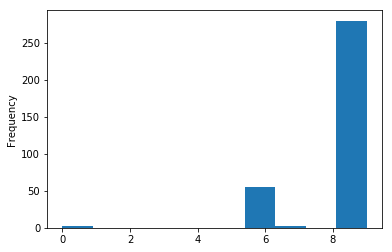

In [221]:
# z-score assumption breaks so the function does not tell us anything of importance
df['grade_span_min'].plot.hist()

***

In [222]:
from scipy import stats

def percentiles(column):
    z_scores = stats.zscore(column)
    # segment based on number of standard deviations away from the mean     
    hist, bin_edges = np.histogram(z_scores, bins=np.arange(-3, 4, 1), density=True)
    return np.stack((hist, bin_edges[1:]))

In [223]:
def too_many_outliers(column, threshold = .05):
    #  expected .021 if normal distribution
    z_less_neg_two = percentiles(column)[0, 0]
    z_gt_two = percentiles(column)[0, -1]
    if z_less_neg_two > threshold or z_gt_two > threshold:
        return np.hstack((column.name, z_less_neg_two, z_gt_two))
    else:
        False

In [224]:
def outlier_columns(df, threshold = .5):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    outlier_columns = np.array([too_many_outliers(df[column]) for column in numeric_columns])
    return np.array([column for column in outlier_columns if column is not None])

In [225]:
def select_outliers(column, upper_tail = True):
    if upper_tail:
        return column[stats.zscore(column) > 2]
    else:
        return column[stats.zscore(column) < -2]

In [226]:
outlier_columns(df)

array([['Lehman College', '0.0', '0.15339233038348082'],
       ['Calculus BC', '0.0', '0.13569321533923304'],
       ['Debate Team', '0.0', '0.10324483775811209'],
       ['Swimming', '0.0', '0.1976401179941003'],
       ['Music', '0.0', '0.1592920353982301'],
       ['Spanish Literature and Culture', '0.0', '0.1710914454277286'],
       ['Peer Mediation', '0.0', '0.12979351032448377'],
       ['Photography', '0.0', '0.168141592920354'],
       ['Peer Tutoring', '0.0', '0.168141592920354'],
       ['Columbia University', '0.0', '0.1415929203539823'],
       ['Yoga', '0.0', '0.12094395280235988'],
       ['Environmental Science', '0.0', '0.18289085545722714'],
       ['Physics B', '0.0', '0.14454277286135694'],
       ['Debate', '0.0', '0.10029498525073746'],
       ['Italian', '0.0', '0.11504424778761062'],
       ['Baseball', '0.0', '0.10914454277286136'],
       ['Newspaper', '0.0', '0.12389380530973451'],
       ['Student Council', '0.0', '0.13569321533923304'],
       ['Spanish', 

***

In [227]:
df.head()

,Science Challenge,Yoga; other clubs based on student interest,Hydroponics Program,Pi Day,Improvisation,SUNY Farmingdale,Fitness Training,Student Government; additional clubs will be formed based on student interest,Spring and Winter Festival for the Performing Arts,South Asian Youth Action (SAYA!),College Trips & Tours,and Flag Football,Virtual Enterprise,Technology Squad,Touro College of Pharmacy,Program REACH,partner_other,Publication (Tech Times),Photovoice Program,Macy's,Test Preparation,Choral Ensemble,coaches and achievements.,Speech and Debate,College Courses,Lady Dragons & Organized Chaos Step Teams,LIU Brooklyn,Saturday Regents Preparatory Program,Iron Chef Cooking,Financial Literacy,After-school Activities,as well as Broadway plays and musicals.,Small Animal Care,Repertorio Espanol,IAM News,The MOTH storytellers,Intramural Seasonal Athletic Program; students participate in the Christopher Columbus PSAL Sports Teams,the Brotherhood and Girl's Group,After-school Classes,US FIRST (For Inspiration and Recognition of Science and Technology) Robotics,Book Club,Olympics Honor Roll,Yoga Program,Freaks and Geeks,Barnard College,Full piano lab with 30 keyboards,Adobe Photoshop,As we expand,St. Johns' University Advantage Program,Math League,Gay/Straight Alliance (GSA),Music Band,Teen Center,Summer in Japan,REACH Advanced Placement Program,Community service projects,Choral Music,USA Wrestling,Women's Club,Arnhold New Dance Teacher Suppport Program,Brave/Respect for All/Diversity Club,Girls Aerobics,Euro- Challenge,IMentor Program (for 9th & 10th),Yearbook; Students are encouraged to initiate clubs pertaining to their individual interests,Shenandoah University,Volunteer and Internship Programs,Reality Works Real Baby Program,My Sister's Keeper (Young Women's Empowerment Group),Culinary Arts,Styling,American College of the Building Arts,K-POP,Stage Crew,Foreign Film,Young People's Project,grade_span_min_is_na,Computer Science AB,Literature Appreciation Program,S!NG,back stage crew program that trains students in running the lights,Columbia University School of Social Work,Green Roof Team,Screen Printing,Political Awareness,Chinese Club,Manhattan College,Junior Class College/Cultural trip to Washington,Brooklyn College Community Partnership Program sponsored activities: Video Production,Theatrical Productions,Peer Leadership Advisories,Find Your Voice acting and playwriting workshops,Harlem Pride Sports,Web Page Design,Wilderness/Camping.,Penny Harvest,High School Talent Show,Literacy,Unity (Girls Club),Spring Vocal and Instrumental Concert,Small Group Tutoring,Nu Gamma Psi,Maximum Dreams,Assembly Committee,Flag Football; Intramural Basketball,Hip-Hop Workshop,Indian Club,Poetry/Creative Writing Team,Seekers,Glee Club,Advanced Visual Arts Classes,Stony Brook University,Civil Air Patrol,Latin Band,Greek,Theatre,Theatrical Performances,Co-ed: Archery,Student/Senior Government,John Jay College of Criminal Justice,Digital Video Production,The following are our higher education partnerships: Fordham University,Young Audiences of NY Arts Program (Choir,Harlem DNA Lab,Archon Student Service Honor Society,Peer Leaders,City University of New York (CUNY) School Support Organization,Liberation,Fitness Team,Lehman College,partner_cultural,Gardening,Football & JV Football,CUNY New York City College of Technology,Advanced Art,SAT Preparation Clubs: Student Council,Young Runners Track,Peer Tutoring Program,College Now at Brooklyn College; Aquatic Research partnership at Brooklyn College,College of Staten Island for College Now classes,City University of New York-CUNY School of Law (at Queens College),Newspaper,Massachusetts Institute of Technology (MIT),Boys Soccer and Co-ed Soccer,Physics,Student Events Committee,NTA_is_na,Revolution SAT Prep,Art & Design,Liberty Partnership,Crimson and Gold yearbook,Yearbook; Students can choose to join over 50 different clubs and organizations,Christian Culture,State University of New York Albany ASR,Women i

***

In [228]:
#df.to_csv('df_pt_1.csv')

In [229]:
columns = df.dtypes[df.dtypes == 'object'].index

In [230]:
object_df = df[columns]

In [231]:
object_df.head()

,partner_other,partner_cultural,partner_corporate,NTA,Location 1,overview_paragraph,addtl_info1,priority02,partner_nonprofit,partner_hospital,end_time,primary_address_line_1,fax_number,ell_programs,addtl_info2,bus,building_code,campus_name,city,priority01,school_accessibility_description,SAT Math Avg. Score,partner_cbo,program_highlights,start_time,borough,Num of SAT Test Takers,SAT Writing Avg. Score,SAT Critical Reading Avg. Score,subway,phone_number,website,priority03
01M292,United Nations,Asia Society,0,Lower East Side ...,"220 Henry Street\nNew York, NY 10002\n(40.7137...",Henry Street School for International Studies ...,0,Then to Manhattan students or residents who at...,Heart of America Foundation,Gouverneur Hospital (Turning Points),3:30 PM,220 Henry Street,212-406-9417,ESL,0,"B39, M14A, M14D, M15, M15-SBS, M21, M22, M9",M056,0,New York,Priority to continuing 8th graders,Functionally Accessible,404,The Henry Street Settlement; Asia Society; Ame...,"Global/International Studies in core subjects,...",8:30 AM,Manhattan,29,363,355,"B, D to Grand St ; F to East Broadway ; J, M, ...",212-406-9411,http://schools.nyc.gov/schoolportals/01/M292,Then to New York City residents who attend an ...
01M448,Movement Research,"Dance Film Association, Dance Makers Film Work...",Deloitte LLP Consulting and Financial Services...,Lower East Side ...,"200 Monroe Street\nNew York, NY 10002\n(40.712...",University Neighborhood High School (UNHS) is ...,Incoming students are expected to attend schoo...,For M35B only: Open only to students whose hom...,"W!SE, Big Brothers Big Sisters, Peer Health Ex...","Gouverneur Hospital, The Door, The Mount Sinai...",3:15 PM,200 Monroe Street,212-267-5611,ESL,"Community Service Requirement, Dress Code Requ...","M14A, M14D, M15, M21, M22, M9",M446,0,New York,Open to New York City residents,Not Functionally Accessible,423,"Grand Street Settlement, Henry Street Settleme...","While attending UNHS, students can earn up to ...",8:15 AM,Manhattan,91,366,383,"F to East Broadway ; J, M, Z to Delancey St-Es...",212-962-4341,www.universityneighborhoodhs.com,0
01M450,Brooklyn Boulders (Rock Climbing),", Internship Program, Loisaida Art Gallery loc...","Prudential Securities, Moore Capital, Morgan S...",East Village ...,"420 East 12 Street\nNew York, NY 10009\n(40.72...",We are a small 6-12 secondary school that prep...,Students present and defend their work to comm...,Then to New York City residents,"College Bound Initiative, Center for Collabora...",0,3:30 PM,420 East 12 Street,212-260-9657,ESL,Our school requires an Academic Portfolio for ...,"M101, M102, M103, M14A, M14D, M15, M15-SBS, M2...",M060,0,New York,Priority to continuing 8th graders,Not Functionally Accessible,402,"University Settlement, Big Brothers Big Sister...",Our Advisory System ensures that we can effect...,8:30 AM,Manhattan,70,370,377,6 to Astor Place ; L to 1st Ave,212-460-8467,www.eschs.org,0
01M509,"CASALEAP, Beacon","Young Audiences, The National Arts Club, Educa...",Estée Lauder,Chinatown ...,"145 Stanton Street\nNew York, NY 10002\n(40.72...",Marta Valle High School (MVHS) offers a strong...,"Students Dress for Success, Summer Bridge to S...",Then to Manhattan students or residents,"College for Every Student (CFES), Morningside ...",Gouvenuer's Hospital,3:30 PM,145 Stanton Street,212-475-7588,ESL,"Community Service Requirement, Extended Day Pr...","B39, M103, M14A, M14D, M15, M15-SBS, M21, M22,...",M025,0,New York,Priority to District 1 students or residents,Functionally Accessible,433,"NYCDOE Innovation Zone Lab Site, Grand Street ...","Advanced Regents Diploma, Early Graduation, up...",8:00 AM,Manhattan,44,384,390,"B, D to Grand St ; F, J, M, Z to Delancey St-E...",212-473-8152,www.martavalle.org,Then to New York City residents
01M539,0,"VH1, Dancing Classrooms, Center for Arts Educa...","Time Warner Cable, Google, IBM, MET Project, S...",Lower East Side ...,"111 Columbia Street\nNew York, NY 10002\n(40.7...","New Explorations into Science,

In [232]:
object_df['SAT Writing Avg. Score'] = pd.to_numeric(object_df['SAT Writing Avg. Score'])

In [233]:
object_df['SAT Writing Avg. Score'].dtype

dtype('int64')

In [234]:
def contains_numbers(column):
    # matches price or percentage     
    regex_string = (r'^(?!.*www|.*-|.*\/|.*[A-Za-z]|.* ).*\d.*')
    #regex_string = (r'\$\d+.*|\d+.*\%$|^\d+.*$')
    return column.str.contains(regex_string).all()

def string_to_numeric(df):
    columns = df.columns[df.apply(contains_numbers)].to_series()
    columns = columns.tolist()
    for column in columns:
        df[column] = pd.to_numeric(df[column])
    return df

In [235]:
df = string_to_numeric(df)

In [236]:
categorical = df.dtypes[df.dtypes == 'object'].index
categorical

Index(['partner_other', 'partner_cultural', 'partner_corporate', 'NTA',
       'Location 1', 'overview_paragraph', 'addtl_info1', 'priority02',
       'partner_nonprofit', 'partner_hospital', 'end_time',
       'primary_address_line_1', 'fax_number', 'ell_programs', 'addtl_info2',
       'bus', 'building_code', 'campus_name', 'city', 'priority01',
       'school_accessibility_description', 'partner_cbo', 'program_highlights',
       'start_time', 'borough', 'subway', 'phone_number', 'website',
       'priority03'],
      dtype='object')

***

# Dealing With Time

In [237]:
#def to_time(df, column):
#    my_time = pd.to_datetime(df[column],format= '%H:%M %p')
#    return my_time

In [238]:
#df['end_time'].head()

In [239]:
#my_timeE = to_time(df, 'end_time')

In [240]:
#my_timeS = to_time(df, 'start_time')

In [241]:
#df['time_diff'] = my_timeE - my_timeS
#df.shape

In [242]:
df = df.drop(['start_time', 'end_time'], axis = 1)

In [243]:
#time = pd.DatetimeIndex(df['time_diff'])

In [244]:
#df['time_diff'] = time.hour * 60 + time.minute

In [245]:
#df['time_diff'].dtype

***

In [246]:
df.shape

(339, 4032)

In [247]:
drop_cols = df.dtypes[df.dtypes == 'object'].index
drop_cols

Index(['partner_other', 'partner_cultural', 'partner_corporate', 'NTA',
       'Location 1', 'overview_paragraph', 'addtl_info1', 'priority02',
       'partner_nonprofit', 'partner_hospital', 'primary_address_line_1',
       'fax_number', 'ell_programs', 'addtl_info2', 'bus', 'building_code',
       'campus_name', 'city', 'priority01', 'school_accessibility_description',
       'partner_cbo', 'program_highlights', 'borough', 'subway',
       'phone_number', 'website', 'priority03'],
      dtype='object')

In [248]:
df = df.drop(drop_cols, axis = 1)

In [249]:
df.shape

(339, 4005)

In [250]:
df.dtypes[df.dtypes == 'o']

Series([], dtype: object)

In [251]:
df.dtypes[df.dtypes == 'str']

Series([], dtype: object)

In [252]:
df.dtypes[df.dtypes == 'object']

Series([], dtype: object)

In [253]:
# After converting all columns to int or float, add new column with sum of SAT section scores for total SAT score
df['SAT Avg. Score'] = df['SAT Writing Avg. Score'] + df['SAT Math Avg. Score'] + df['SAT Critical Reading Avg. Score']

In [254]:
df.dtypes.unique()

array([dtype('float64'), dtype('bool'), dtype('int64')], dtype=object)

In [255]:
df = df.replace([True, False], [1,0])

In [256]:
df.head(3)

,Science Challenge,Yoga; other clubs based on student interest,Hydroponics Program,Pi Day,Improvisation,SUNY Farmingdale,Fitness Training,Student Government; additional clubs will be formed based on student interest,Spring and Winter Festival for the Performing Arts,South Asian Youth Action (SAYA!),College Trips & Tours,and Flag Football,Virtual Enterprise,Technology Squad,Touro College of Pharmacy,Program REACH,Publication (Tech Times),Photovoice Program,Macy's,Test Preparation,Choral Ensemble,coaches and achievements.,Speech and Debate,College Courses,Lady Dragons & Organized Chaos Step Teams,LIU Brooklyn,Saturday Regents Preparatory Program,Iron Chef Cooking,Financial Literacy,After-school Activities,as well as Broadway plays and musicals.,Small Animal Care,Repertorio Espanol,IAM News,The MOTH storytellers,Intramural Seasonal Athletic Program; students participate in the Christopher Columbus PSAL Sports Teams,the Brotherhood and Girl's Group,After-school Classes,US FIRST (For Inspiration and Recognition of Science and Technology) Robotics,Book Club,Olympics Honor Roll,Yoga Program,Freaks and Geeks,Barnard College,Full piano lab with 30 keyboards,Adobe Photoshop,As we expand,St. Johns' University Advantage Program,Math League,Gay/Straight Alliance (GSA),Music Band,Teen Center,Summer in Japan,REACH Advanced Placement Program,Community service projects,Choral Music,USA Wrestling,Women's Club,Arnhold New Dance Teacher Suppport Program,Brave/Respect for All/Diversity Club,Girls Aerobics,Euro- Challenge,IMentor Program (for 9th & 10th),Yearbook; Students are encouraged to initiate clubs pertaining to their individual interests,Shenandoah University,Volunteer and Internship Programs,Reality Works Real Baby Program,My Sister's Keeper (Young Women's Empowerment Group),Culinary Arts,Styling,American College of the Building Arts,K-POP,Stage Crew,Foreign Film,Young People's Project,grade_span_min_is_na,Computer Science AB,Literature Appreciation Program,S!NG,back stage crew program that trains students in running the lights,Columbia University School of Social Work,Green Roof Team,Screen Printing,Political Awareness,Chinese Club,Manhattan College,Junior Class College/Cultural trip to Washington,Brooklyn College Community Partnership Program sponsored activities: Video Production,Theatrical Productions,Peer Leadership Advisories,Find Your Voice acting and playwriting workshops,Harlem Pride Sports,Web Page Design,Wilderness/Camping.,Penny Harvest,High School Talent Show,Literacy,Unity (Girls Club),Spring Vocal and Instrumental Concert,Small Group Tutoring,Nu Gamma Psi,Maximum Dreams,Assembly Committee,Flag Football; Intramural Basketball,Hip-Hop Workshop,Indian Club,Poetry/Creative Writing Team,Seekers,Glee Club,Advanced Visual Arts Classes,Stony Brook University,Civil Air Patrol,Latin Band,Greek,Theatre,Theatrical Performances,Co-ed: Archery,Student/Senior Government,John Jay College of Criminal Justice,Digital Video Production,The following are our higher education partnerships: Fordham University,Young Audiences of NY Arts Program (Choir,Harlem DNA Lab,Archon Student Service Honor Society,Peer Leaders,City University of New York (CUNY) School Support Organization,Liberation,Fitness Team,Lehman College,Gardening,Football & JV Football,CUNY New York City College of Technology,Advanced Art,SAT Preparation Clubs: Student Council,Young Runners Track,Peer Tutoring Program,College Now at Brooklyn College; Aquatic Research partnership at Brooklyn College,College of Staten Island for College Now classes,City University of New York-CUNY School of Law (at Queens College),Newspaper,Massachusetts Institute of Technology (MIT),Boys Soccer and Co-ed Soccer,Physics,Student Events Committee,NTA_is_na,Revolution SAT Prep,Art & Design,Liberty Partnership,Crimson and Gold yearbook,Yearbook; Students can choose to join over 50 different clubs and organizations,Christian Culture,State University of New York Albany ASR,Women in Technology,and Yearbook. Midw

In [257]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

In [258]:
#df.to_csv('df_pt_2.csv')

In [91]:
bools = []
for column in df.columns:
    
    non_bool = pd.Series([not (i == 1 or i == 0) for i in df[column]]).all()
    bools.append(non_bool)

non_bools = df.columns[bools]   

In [92]:
df_reduced = df[non_bools]
df_reduced.columns

Index(['total_students', 'SAT Math Avg. Score', 'Num of SAT Test Takers',
       'SAT Writing Avg. Score', 'SAT Critical Reading Avg. Score',
       'SAT Avg. Score'],
      dtype='object')

In [93]:
df_reduced.head(1)

,total_students,SAT Math Avg. Score,Num of SAT Test Takers,SAT Writing Avg. Score,SAT Critical Reading Avg. Score,SAT Avg. Score
01M292,323.0,404,29,363,355,1122


In [94]:
corr = df_reduced.corr(method = 'spearman')

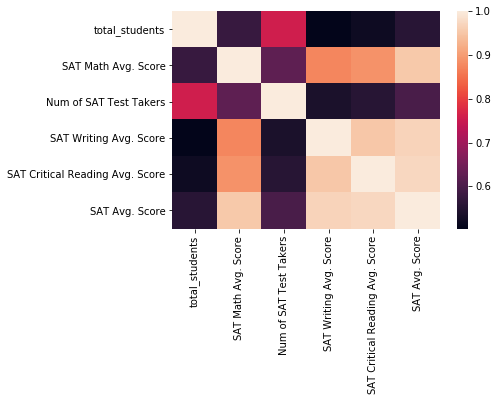

In [95]:
import seaborn as sns

ax = sns.heatmap(corr)

***

# RFE

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [97]:
y = df['SAT Avg. Score']

In [98]:
X = df.drop(columns = ['SAT Avg. Score'])

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [100]:
from sklearn.feature_selection import RFECV
model = LinearRegression(n_jobs = -1)
rfecv = RFECV(model, cv = 5)
X_train_rfecv = rfecv.fit(X_train,y_train)

In [101]:
grid_scores = X_train_rfecv.grid_scores_
x_value_range = list(range(0, 303))[::-1]

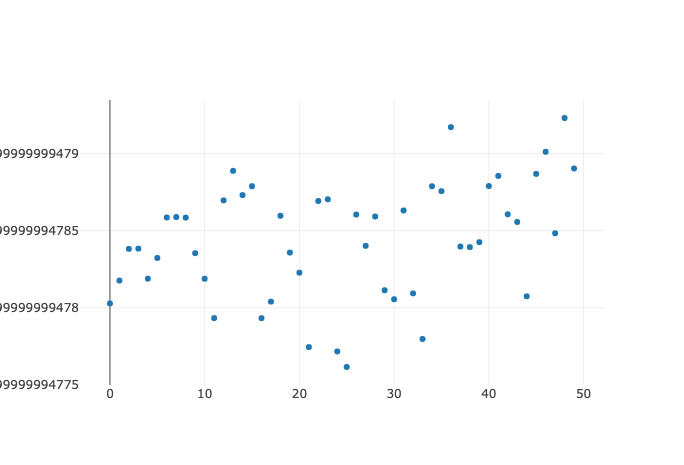

In [102]:
from graph import trace_values, plot
score_trace = trace_values(x_value_range[-50:], grid_scores[-50:])
plot([score_trace])

In [103]:
from sklearn.feature_selection import RFE
selectors = []
for idx in list(range(2, 300, 10))[::-1]:
    estimator = LinearRegression(n_jobs=-1)
    rfe = RFE(estimator, idx, step=1)
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    
    estimator.fit(X_train_rfe,y_train)
    score = estimator.score(X_test_rfe,y_test)
    selectors.append((estimator, score, idx))

KeyboardInterrupt: 

In [ ]:
import numpy as np
wrapped_selectors = np.array(selectors)
wrapped_selectors[:3]

In [ ]:
n_features = wrapped_selectors[:, -1]
n_features[:5]

In [ ]:
scores = wrapped_selectors[:, 1]
scores[:5]

In [ ]:
from graph import trace_values, plot
scores_trace = trace_values(n_features, scores)
plot([scores_trace])